# Ukranian Audio Digits Recognition

## Environment Setup

In [61]:

from colabcode import ColabCode

In [ ]:
%%writefile requirements.txt

torch #pytorch
torchvision
matplotlib
numpy
tqdm
pandas
opencv-python #cv2
albumentations

In [ ]:
!pip install -r requirements.txt

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from misc.constants import CONST
from misc.setup import Initializer
import librosa
from scipy.fftpack import dct
import librosa.display

## Project misc functions

In [ ]:
def count_paths(paths):
    count_woman = sum('woman' in path.lower() for path in paths)
    count_man = sum('man' in path.lower() and 'woman' not in path.lower() for path in paths)

    return count_woman, count_man

## Project Setup

In [ ]:
initializer = Initializer(CONST.DATA_PATH)
initializer.initialize_project()

## Simple Data Analys

Our dataset contain recordings of digits from `0` to `1`. We implement this dataset by ourselves. In total we have 100 different men women voices with different age starting from `10` ending `60`. However the median and mode is about `20` years old. 

In [65]:
df = pd.read_csv(CONST.CSV_PATH)

print("Total amount of recordings: ", len(df))

Total amount of recordings:  879


In [66]:
df.head()

,file_path,label
0,/Users/dimaevcenko/Documents/spoken_digit_proj...,0
1,/Users/dimaevcenko/Documents/spoken_digit_proj...,5
2,/Users/dimaevcenko/Documents/spoken_digit_proj...,4
3,/Users/dimaevcenko/Documents/spoken_digit_proj...,6
4,/Users/dimaevcenko/Documents/spoken_digit_proj...,7


In [67]:
count_woman, count_man = count_paths(df['file_path'].tolist())

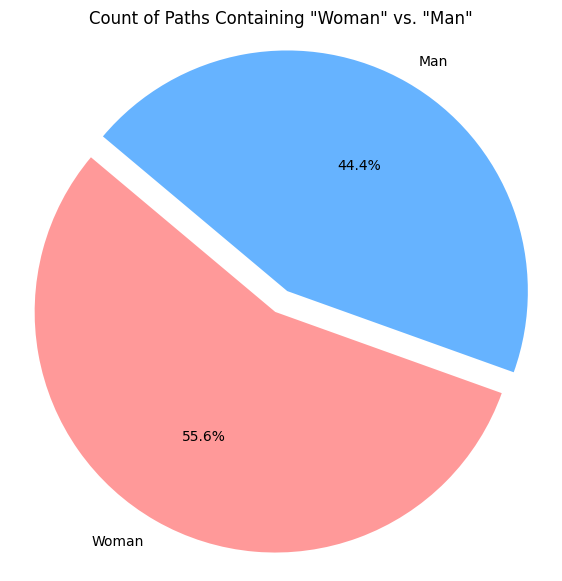

In [68]:
labels = ['Woman', 'Man']
sizes = [count_woman, count_man]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Count of Paths Containing "Woman" vs. "Man"')
plt.show()

## Data Processing

In [69]:
df_subset = df.head(15)

mfcc_features = []
for file_path in df_subset['file_path']:
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfcc_features.append(mfccs_mean)

df_subset['MFCC'] = mfcc_features

/var/folders/nw/pb0znbfj0r3288jhzshl4c8h0000gn/T/ipykernel_39471/1652113668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['MFCC'] = mfcc_features


### Visualize MFCC

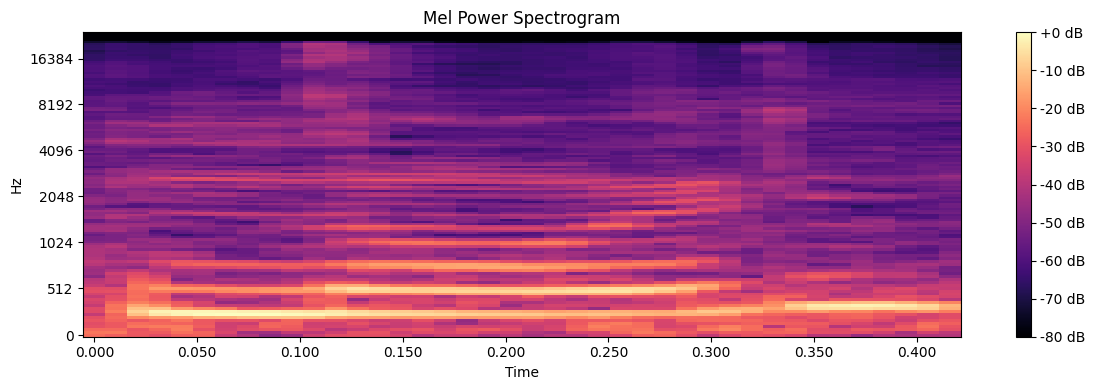

In [70]:
file_path = df_subset['file_path'].iloc[0]
audio, sample_rate = librosa.load(file_path, sr=None)

S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))

librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')

plt.title('Mel Power Spectrogram')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()
plt.show()

In [71]:
from lfcc import lfcc

lfcc_features = []
for file_path in df_subset['file_path']:
    audio, sample_rate = librosa.load(file_path, sr=None)
    lfccs = lfcc(y=audio, sr=sample_rate)
    lfcc_features.append(lfccs)


df_subset['LFCC'] = lfcc_features

/var/folders/nw/pb0znbfj0r3288jhzshl4c8h0000gn/T/ipykernel_39471/1548102055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['LFCC'] = lfcc_features


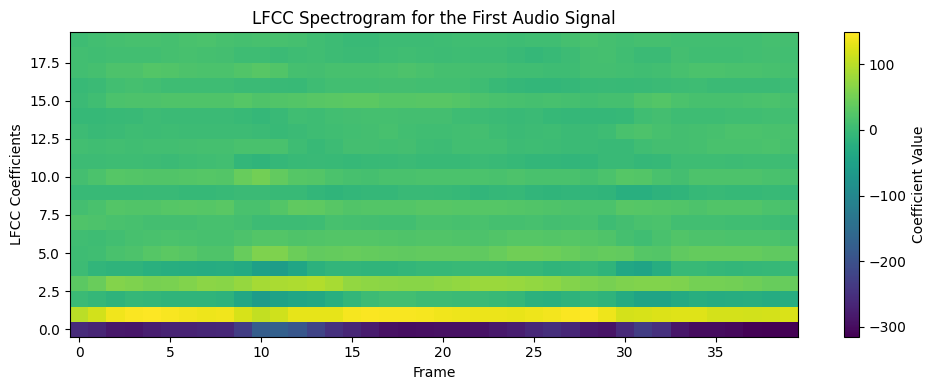

In [72]:
first_lfcc_features = lfcc_features[0]
plt.figure(figsize=(10, 4))
plt.imshow(first_lfcc_features, aspect='auto', origin='lower', cmap='viridis')
plt.title('LFCC Spectrogram for the First Audio Signal')
plt.ylabel('LFCC Coefficients')
plt.xlabel('Frame')
plt.colorbar(label='Coefficient Value')
plt.tight_layout()
plt.show()

## CQCC Implementation and saving according to audio file

In [73]:
from scipy.interpolate import interp1d
def extract_CQCC(file_path, n_bins=96, fmin=None, fmax=None, n_ceps=13):
    audio_path = file_path
    y, sr = librosa.load(audio_path)
    if fmin is None:
        fmin = librosa.note_to_hz('C1')
    # Ensure maximum frequency is set, default to Nyquist
    if fmax is None:
        fmax = sr / 2
    CQT = np.abs(librosa.cqt(y, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=n_bins//8, hop_length=512))
    log_CQT = np.log(CQT**2 + np.finfo(float).eps)
    freqs = librosa.cqt_frequencies(n_bins, fmin = fmin, bins_per_octave=n_bins//8)
    target_freqs = np.linspace(freqs[0], freqs[-1], num=log_CQT.shape[0])
    resampled_log_CQT = np.zeros_like(log_CQT)
    for i in range(log_CQT.shape[1]):
        interp_func = interp1d(freqs, log_CQT[:, i])
        resampled_log_CQT[:, i] = interp_func(target_freqs)

    cqcc = dct(resampled_log_CQT, type=2, axis=0, norm='ortho')[:n_ceps, :]

    return cqcc

cqcc_features = []
for file_path in df_subset['file_path']:
    cqcc = extract_CQCC(file_path)
    cqcc_features.append(cqcc)

df_subset['CQCC'] = cqcc_features

/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=73
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=68
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=87
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=72
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=76
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=105
  warnings.warn(
/Library/Python/3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal 

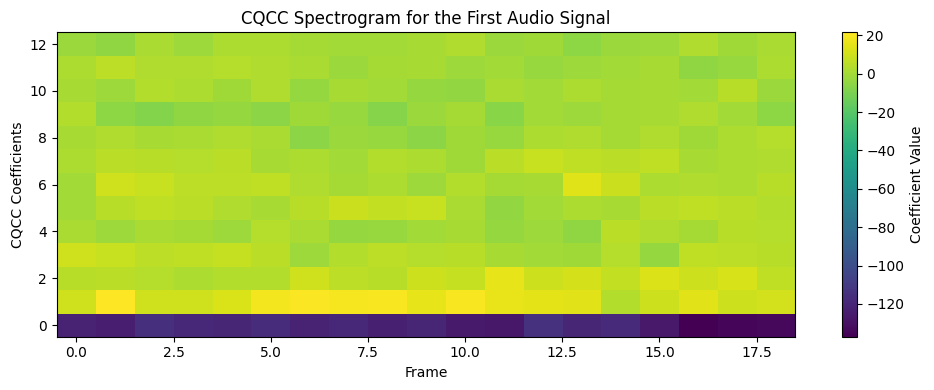

In [74]:
first_cqcc_features = cqcc_features[0]
plt.figure(figsize=(10, 4))
plt.imshow(first_cqcc_features, aspect='auto', origin='lower', cmap='viridis')
plt.title('CQCC Spectrogram for the First Audio Signal')
plt.ylabel('CQCC Coefficients')
plt.xlabel('Frame')
plt.colorbar(label='Coefficient Value')
plt.tight_layout()
plt.show()

In [75]:
print(df_subset.head())

                                           file_path  label  \
0  /Users/dimaevcenko/Documents/spoken_digit_proj...      0   
1  /Users/dimaevcenko/Documents/spoken_digit_proj...      5   
2  /Users/dimaevcenko/Documents/spoken_digit_proj...      4   
3  /Users/dimaevcenko/Documents/spoken_digit_proj...      6   
4  /Users/dimaevcenko/Documents/spoken_digit_proj...      7   

                                                MFCC  \
0  [-399.16827, 119.56348, 14.460864, 45.340397, ...   
1  [-353.32925, 120.74446, 5.925511, 25.075254, 0...   
2  [-358.8274, 102.72849, 4.879433, 37.750263, -0...   
3  [-340.9078, 46.635857, -3.3306942, 66.18793, 5...   
4  [-338.93134, 49.50678, 11.878546, 62.033737, -...   

                                                LFCC  \
0  [[-258.15607, -266.57797, -284.6463, -286.7906...   
1  [[-314.65482, -306.63306, -293.27417, -280.030...   
2  [[-308.1536, -278.62332, -192.48691, -127.9304...   
3  [[-278.4126, -280.55695, -247.49904, -196.6879...   
4  [